# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Описание данных
id — уникальный идентификатор скважины;  
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);  
product — объём запасов в скважине (тыс. баррелей).  
### Условия задачи:
Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).  
При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.  
Бюджет на разработку скважин в регионе — 10 млрд рублей.  
При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.  
После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.  
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.  

### Оглавление:
1. [Загрузка и подготовка данных](#1)  
    1.1 [Первый регион](#1.1)  
    1.2 [Второй регион](#1.2)  
    1.3 [Третий регион](#1.3)  
    1.4 [Вывод](#1.4)  
2. [Обучение и проверка модели](#2)  
    2.1. [Обучение и проверка модели](#2)  
    2.2. [Вывод](#2.1)  
3. [Подготовка к расчёту прибыли](#3)  
    3.1 [Подготовка к расчёту прибыли](#3)  
    3.2 [Вывод](#3.1)  
4. [Расчёт прибыли по выбранным скважинам и предсказаниям модели](#4)
5. [Расчёт прибыли и рисков](#5)  
    5.1 [Расчёт прибыли и рисков](#5)  
    5.2 [Вывод](#5.1)  
6. [Общий вывод](#6)

<a id="1"></a>
## 1. Загрузка и подготовка данных

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle

<a id="1.1"></a>
### 1.1 Первый регион

In [6]:
try:
    data_0 = pd.read_csv("geo_data_0.csv")
except:
    data_0 = pd.read_csv("/datasets/geo_data_0.csv")
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В нашем ДФ 100000 строк, 5 столбцов. Пропущенных значений у нас нет, тип данных соответствует самим данным

<AxesSubplot:>

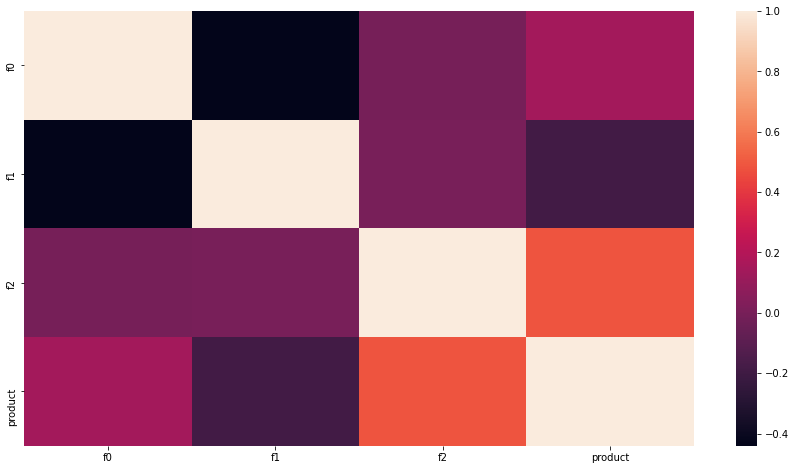

In [9]:
corr_0 = data_0.corr()
plt.subplots(figsize=(15,8))
sns.heatmap(corr_0, xticklabels=corr_0.columns.values, yticklabels=corr_0.columns.values)

Сильной связи между данными так же не наблюдаем

In [12]:
data_0["id"].nunique()

99990

Есть повторяющиеся id я сделаю вывод что просто из нескольких мест брали пробы не единожды

In [14]:
data_0.duplicated().sum()

0

Дубликатов в наших данных нет

<a id="1.2"></a>
### 1.2 Второй регион

In [15]:
try:
    data_1 = pd.read_csv("geo_data_1.csv")
except:
    data_1 = pd.read_csv("/datasets/geo_data_1.csv")
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [16]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В нашем ДФ 100000 строк, 5 столбцов. Пропущенных значений у нас нет, тип данных соответствует самим данным

<AxesSubplot:>

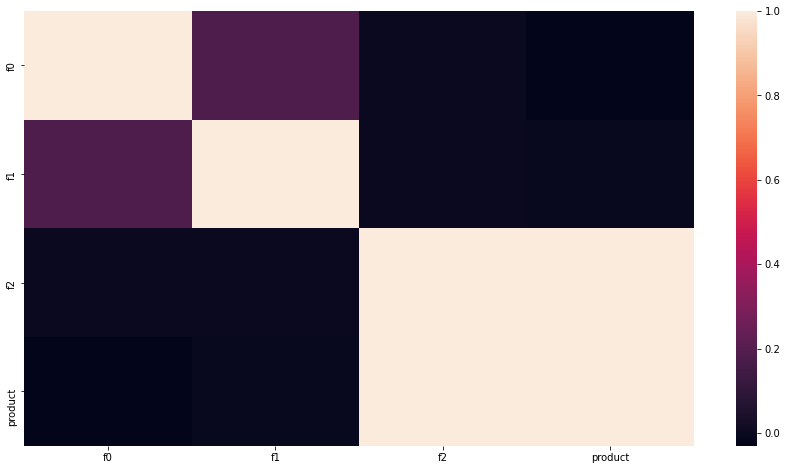

In [21]:
corr_1 = data_1.corr()
plt.subplots(figsize=(15,8))
sns.heatmap(corr_1, xticklabels=corr_1.columns.values, yticklabels=corr_1.columns.values)

In [25]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


Есть зависимость между третьим признаком и объём запасов в скважине

In [22]:
data_1["id"].nunique()

99996

Есть повторяющиеся id, из нескольких мест брали пробы не единожды

In [23]:
data_1.duplicated().sum()

0

Дубликатов в наших данных нет

<a id="1.3"></a>
### 1.3 Третий регион

In [20]:
try:
    data_2 = pd.read_csv("geo_data_2.csv")
except:
    data_2 = pd.read_csv("/datasets/geo_data_2.csv")
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [26]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


В нашем ДФ 100000 строк, 5 столбцов. Пропущенных значений у нас нет, тип данных соответствует самим данным

<AxesSubplot:>

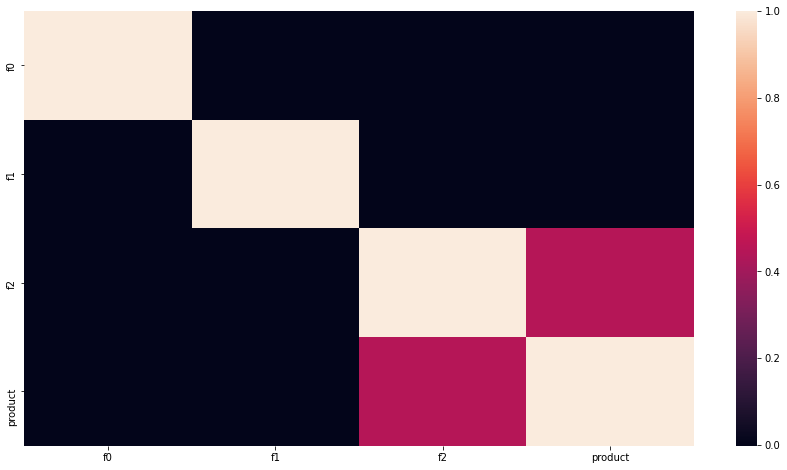

In [27]:
corr_2 = data_2.corr()
plt.subplots(figsize=(15,8))
sns.heatmap(corr_2, xticklabels=corr_2.columns.values, yticklabels=corr_2.columns.values)

In [28]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Сильной связи между данными не наблюдаем

In [29]:
data_2["id"].nunique()

99996

Есть повторяющиеся id, из нескольких мест брали пробы не единожды

In [30]:
data_1.duplicated().sum()

0

Дубликатов в наших данных нет

<a id="1.4"></a>
### 1.4 Вывод:
> Данные подготовлены хорошо, пропусков, дубликатов нет, все типы данных соответствуют сами данным, можем началть обучать нашу модель

<a id="2"></a>
## 2. Обучение и проверка модели

In [97]:
#обучим наши модели через цикл
rmse_list = []
predict_list = []
score_list = []
predict_df = pd.DataFrame()
target_df = pd.DataFrame()

for i,j in zip([data_0,data_1,data_2],range(3)):
    feature = i.drop(["id","product"], axis=1)
    target = i["product"]
    feature_train, feature_valid, target_train, target_valid = train_test_split(feature, \
                                                                                target, test_size=0.25, random_state=12345) 
    model = LinearRegression()
    model.fit(feature_train, target_train)
    predict = model.predict(feature_valid)
    rmse = mean_squared_error(target_valid, predict) ** 0.5
    rmse_list.append(rmse)
    predict_list.append(predict.mean())
    score_list.append(model.score(feature_train, target_train))
    target_df[j] = target_valid
    predict_df[j] = predict
target_df = target_df.reset_index(drop=True)

In [94]:
#создадим датафрейм и сравним результаты

df = pd.DataFrame(data=[rmse_list, score_list, predict_list], index=['RMSE','Score','Predict_mean'], \
    columns=['region_1','region_2','region_3'])
df

,region_1,region_2,region_3
RMSE,37.579422,0.893099,40.029709
Score,0.274239,0.999625,0.196614
Predict_mean,92.592568,68.728547,94.965046


<a id="2.1"></a>
### 2.2 Вывод:
> Модели **первого** и **третьего** региона показывают не очень хорошие (плохие) результаты, не стоит их использовать для выбора скважин в регионе.  А модель второго региона показала очень хорошие результаты, но ее я брать бы не стал, хороший результат скорее всего из-за зависимости данных


<a id="3"></a>
## Подготовка к расчёту прибыли

In [63]:
# условия нашей задаси
budget = 10000000000 #бюджет на разработку скважин в регионе 10 млрд. рублей
total_rec = 500 #исследование 500 точек
profit_wells = 200 #200 лучших скважин для расчета прибыли
profit_from_one_barrel = 450 #прибыль с одного барреля сырья 450 рублей
profit_from_one_product = 450000 #доход с каждой единицы продукта 450 000 рублей

In [64]:
#цена за бурение одной скважины
one_price = budget / profit_wells
one_price

50000000.0

Цена за бурение одной скважина составляет 50 млн. рублей

In [66]:
#посчитаем достаточный объем сырья для безубыточной разработки новой скважины
min_product  = one_price/profit_from_one_product
min_product

111.11111111111111

Минимальный объем сырья в каждой скважине должен составлять 111 тыс барелей

<a id="3.1"></a>
### Вывод:
> Средний запас сырья в каждом регионе (перый - 92.5 тыс барелей, второй - 68.8 тыс барелей, третий - 95 тыс барелей) не соответствуют минимальному объему сырья в каждой скважине

<a id="4"></a>
## 4. Расчёт прибыли по выбранным скважинам и предсказаниям модели

In [99]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return (450000 * selected.sum() - (budget))
print('Прибыль первого региона : {:.4f} млрд рублей'.format(revenue(target_df[0], predict_df[0],200)/10**9))
print('Прибыль второго региона : {:.4f} млрд рублей'.format(revenue(target_df[1], predict_df[1],200)/10**9))
print('Прибыль третьего региона :{:.4f} млрд рублей'.format(revenue(target_df[2], predict_df[2],200)/10**9))

Прибыль первого региона : 3.3208 млрд рублей
Прибыль второго региона : 2.4151 млрд рублей
Прибыль третьего региона :2.7103 млрд рублей


<a id="5"></a>
## 5. Расчёт прибыли и рисков 

In [111]:
#посчитаем риски и прибыль для первого региона применив технику bootstrap с 1000 выборками, 
#95 % доверительный интервал и риск убытков

state = np.random.RandomState(12345)
values_0 = []

for i in range(1000):
    target_subsample_0 = target_df[0].sample(n=500, replace=True, random_state=state)
    prons_subsample_0 = predict_df[0][target_subsample_0.index]
    
    values_0.append(revenue(target_subsample_0, prons_subsample_0, 200))
    
values_0 = pd.Series(values_0)
mean_0 = values_0.mean() / 10**9 #посчитаем в мрд рублей
risks_0 = (values_0 < 0).mean() * 100 #посчитаем в процентах
interval_0 = (values_0.quantile(0.025), values_0.quantile(0.975))
print("Средняя прибыль: {:.2f}".format(mean_0))
print("Риск: {:.2f}".format(risks_0))
print("95%-й доверительный интервал:", interval_0)

Средняя прибыль: 0.43
Риск: 6.00
95%-й доверительный интервал: (-102090094.83793654, 947976353.358369)


In [113]:
#посчитаем риски и прибыль для второго региона применив технику bootstrap с 1000 выборками, 
#95 % доверительный интервал и риск убытков

values_1 = []

for i in range(1000):
    target_subsample_1 = target_df[1].sample(n=500, replace=True, random_state=state)
    prons_subsample_1 = predict_df[1][target_subsample_1.index]
    
    values_1.append(revenue(target_subsample_1, prons_subsample_1, 200))
    
values_1 = pd.Series(values_1)
mean_1 = values_1.mean() / 10**9
risks_1 = (values_1 < 0).mean() * 100
interval_1 = (values_1.quantile(0.025), values_1.quantile(0.975))
print("Средняя прибыль: {:.2f}".format(mean_1))
print("Риск: {:.2f}".format(risks_1))
print("95%-й доверительный интервал:", interval_1)

Средняя прибыль: 0.52
Риск: 0.30
95%-й доверительный интервал: (128123231.43308629, 953612982.0669085)


In [114]:
#посчитаем риски и прибыль для третьего региона применив технику bootstrap с 1000 выборками, 
#95 % доверительный интервал и риск убытков

values_2 = []

for i in range(1000):
    target_subsample_2 = target_df[2].sample(n=500, replace=True, random_state=state)
    prons_subsample_2 = predict_df[2][target_subsample_2.index]
    
    values_2.append(revenue(target_subsample_2, prons_subsample_2, 200))
    
values_2 = pd.Series(values_2)
mean_2 = values_2.mean() / 10**9
risks_2 = (values_2 < 0).mean() * 100
interval_2 = (values_2.quantile(0.025), values_2.quantile(0.975))
print("Средняя прибыль: {:.2f}".format(mean_2))
print("Риск: {:.2f}".format(risks_2))
print("95%-й доверительный интервал:", interval_2)

Средняя прибыль: 0.42
Риск: 6.20
95%-й доверительный интервал: (-115852609.16001143, 989629939.844574)


<a id="5.1"></a>
### Вывод:
> Второй регион показывает самый лучший результат с наименьшим риском, но из-за данных я бы не стал там бурить, на основании этого для бурения больше всего подходит первый регион

<a id="6"></a>
# Общий вывод
> Нам было предложено исследовать 3 региона для исследования возможности бурения новой скважины. Все данные в датасетах были подготовлены хорошо, небыло пропущенных значений и дубликатов. Но второй ДФ отличался от двух других наличием большой связи между данными.   
При обучении наших моделей второй регион показал наилучшие результаты, но из-за зависимости между данными мы не стали рассматривать эту модель.  
При подсчете среднего запаса сырья в каждом регионе выявили несоответствие минимальному объему сырья в каждой скважине.  
Самым прибыльным регионом оказался первый регион с прибылью 3.3208 млрд рублей.
При оценке рисков, второй регион показал наилучший результат, но из-за данных, мы не рекомендуем его расссматривать, поэтому лучшим регионом бля будения скважины считам первый регон **средняяя прибыть** равна **0.43** млр. рублей, риск **6%**
